## The transient Universe

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats as stats
from scipy import optimize

In [47]:
# read array
data = np.load('transient.npy')

Text(0, 0.5, 'flux')

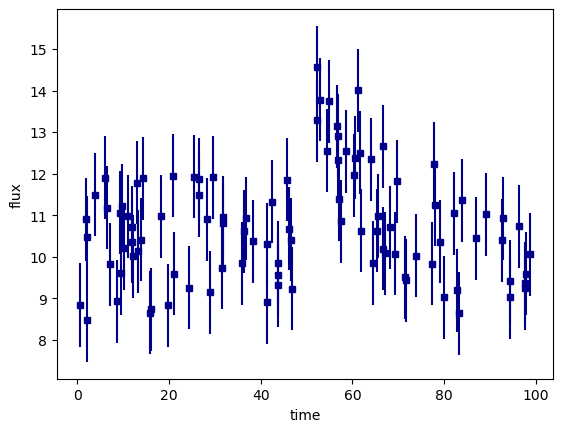

In [48]:
plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None',marker='s',color='darkblue',markersize=3.8)
plt.xlabel('time')
plt.ylabel('flux')

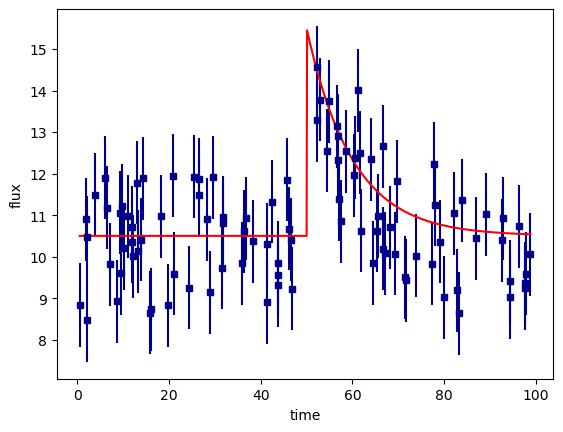

In [49]:
# parameters by hands
b = 10.5
A = 5
alpha = 1/10
t0 = 50

# function for the fit
def burst(t, params):
    b, A, lnalpha, t0 = params
    alpha = np.exp(lnalpha)
    return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
    
time = np.linspace(data[0,0],data[-1,0],1000)
flux = burst(time, [b,A,np.log(alpha),t0])
    
# plot
plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None',marker='s',color='darkblue',markersize=3.8)
plt.plot(time, flux, color='red')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

### $y = b+A\cdot e^{-\alpha (t-t_0)}$

### emcee

In [52]:
x_data = data[:,0]
y_data = data[:,1]
y_uncertainty = data[:,2]

bounds = [(0,50), (0,50), (-5,5), (0,100)]     # priors intervals
  
# Gaussian likelihood
def lnLikelihood(params, x_data, y_data, y_uncertainty):
    y_pred = burst(x_data, params)
    return 0.5*np.sum(-(y_data - y_pred)**2 / (2 * y_uncertainty**2))

# Uniform priors
def lnPrior(params):
    b, A, lnalpha, t0 = params
    if all(a<p<b for (a,b),p in zip(bounds,params)):
        return 0.
    else:
        return -np.inf  
    
# Posterior
def lnPosterior(params, x_data, y_data, y_uncertainty):
    return lnLikelihood(params, x_data, y_data, y_uncertainty) + lnPrior(params)

# Parameters and inizialization
ndim = 4           
nwalkers = 10      
nsteps = 100000    

np.random.seed(0)
starting_guesses = np.random.random((nwalkers,ndim))
starting_guesses[:,0] += 10
starting_guesses[:,1] += 4
starting_guesses[:,2] += -1
starting_guesses[:,3] += 50

# Perform MCMC with emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior, args=[x_data, y_data, y_uncertainty])
sampler.run_mcmc(starting_guesses, nsteps)

print('Done.')

Done.


In [59]:
# Get trace 
burn = 10000
emcee_trace = sampler.chain[:, burn:, :].reshape(-1, ndim)
emcee_trace.shape

(900000, 4)

In [60]:
# Thinning
tau = sampler.get_autocorr_time()
thin = int(max(tau)+1)       # different autocorrelation time for each parameter --> take the largest one to avoid autocorr.
thin

161

In [61]:
labels = ["b", "A", "ln\u03B1", "$t_0$"]
plabels = ["b", "A", "ln\u03B1", "to"]
colors = ['royalblue', 'darkorange', 'green', 'darkred']

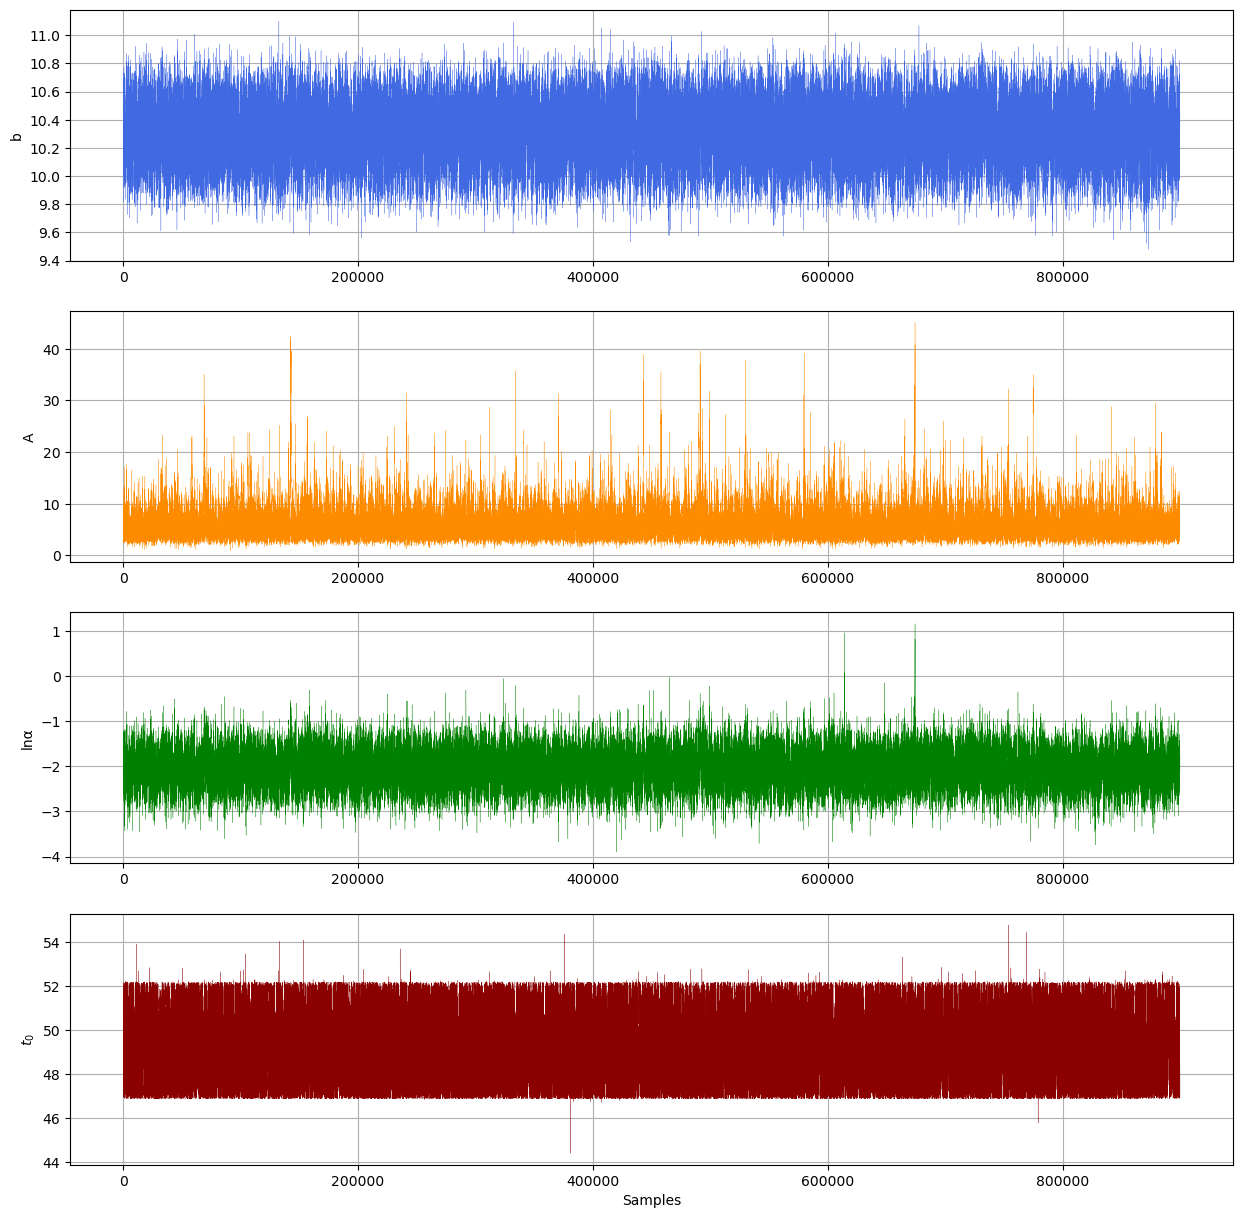

In [62]:
# Trace plot
xgrid = np.linspace(1, len(emcee_trace[:]), len(emcee_trace[:]))
fig = plt.figure(figsize=(15, 15))

for i in range(4):
    ax = fig.add_subplot(4,1,i+1)
    ax.plot(xgrid, emcee_trace[:, i], lw=0.2, color=colors[i], label=labels[i])  
    plt.grid()
    plt.ylabel(labels[i])
plt.xlabel('Samples')
plt.show()

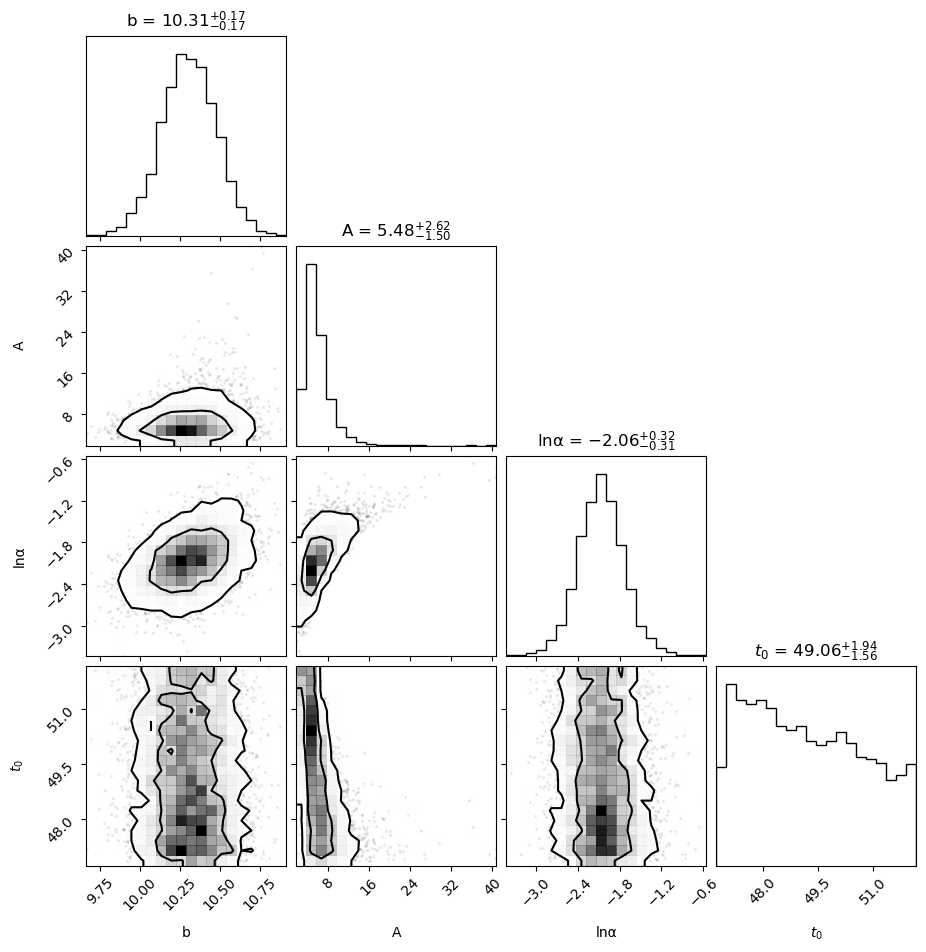

In [63]:
# Corner plot
import corner

flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)   

fig = corner.corner(flat_samples, labels=labels, levels=[0.68, 0.95], show_titles=True)
plt.show()

Parameter estimate (mean):
b  =  10.306052165272856
A  =  6.0900428033412854
α  =  0.12771686719691677
to =  49.222621088036306


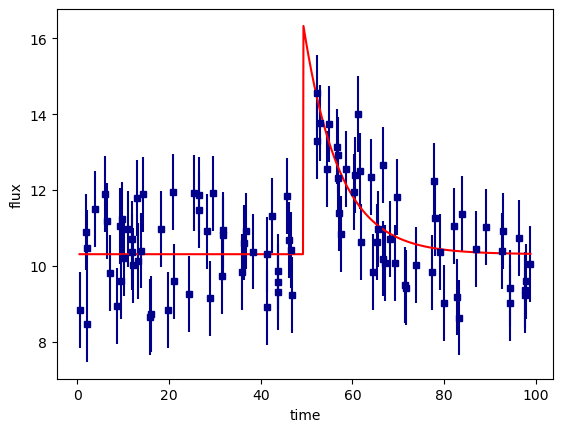

In [64]:
# Burst model with estimated parameters
mean_params = np.mean(emcee_trace, axis=0)     
b, A, lnalpha, t0 = mean_params
alpha = np.exp(lnalpha)

print("Parameter estimate (mean):")
print("b  = ", b)
print("A  = ", A)
print("\u03B1  = ", alpha)
print("to = ", t0)
  
time = np.linspace(data[0,0],data[-1,0],1000)
flux = burst(time,mean_params)

# plot
plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None',marker='s',color='darkblue',markersize=3.8)
plt.plot(time,flux,color='red')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

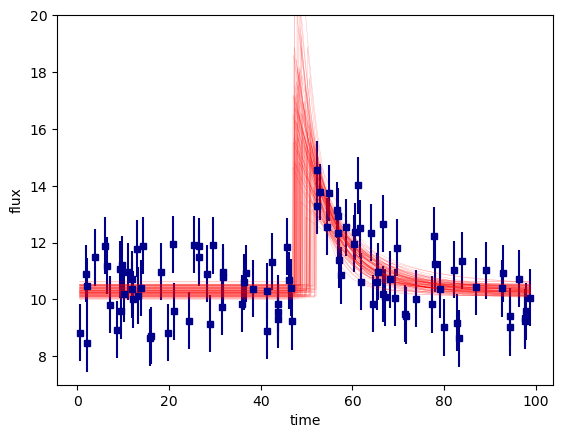

In [65]:
# Plot 100 random samples

plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None',marker='s',color='darkblue',markersize=3.8)

for j in range(100):
    par = emcee_trace[np.random.randint(0, len(emcee_trace))]    # get random parameter samples from trace
    flux = burst(time, par)
    
    plt.plot(time,flux,color='red',alpha=0.3,linewidth=0.3)
plt.xlabel('time')
plt.ylabel('flux')
plt.ylim(7,20)
plt.show()

In [66]:
for i in range(4):
    low, median, up = np.percentile(flat_samples[:,i],[5,50,95]) 
    print(plabels[i]," =", round(median,2)," +",round(up-median,2)," -",round(median-low,2))

b  = 10.31  + 0.28  - 0.28
A  = 5.48  + 5.38  - 2.17
lnα  = -2.06  + 0.56  - 0.52
to  = 49.06  + 2.77  - 1.99


### Nested Sampling

In [14]:
import dynesty

In [15]:
x_data = data[:,0]
y_data = data[:,1]
y_uncertainty = data[:,2]

bounds = [(0,50), (0,50), (-5,5), (0,100)]     # priors intervals

In [16]:
def logL(params):
    y_pred = burst(x_data, params)
    return 0.5*np.sum((-(y_data - y_pred)**2 / (2 * y_uncertainty**2)) - np.log(2*np.pi * y_uncertainty**2))

def ptform(u):
    return [a + (b - a) * ui for ui, (a, b) in zip(u, bounds)]

In [17]:
ndim = 4

sampler = dynesty.NestedSampler(logL, ptform, ndim)
sampler.run_nested()
results = sampler.results

/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
1761it [00:07, 100.23it/s, bound: 0 | nc: 20 | ncall: 17525 | eff(%): 10.049 | loglstar:   -inf < -179.639 <    inf | logz: -187.695 +/-  0.117 | dlogz: 59.388 >  0.509]    /tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
1772it [00:08, 42.02it/s, bound: 1 | nc: 1 | ncall: 17743 | eff(%):  9.987 | loglstar:   -inf < -177.775 <    inf | logz: -185.815 +/-  0.118 | dlogz: 57.505 >  0.509]  /tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
1834it [00:08, 93.53it/s, bound: 1 | nc: 3 | ncall: 18346 | eff(%):  9.997 | loglstar:   -inf < -170

2942it [00:36, 69.76it/s, bound: 14 | nc: 18 | ncall: 28187 | eff(%): 10.437 | loglstar:   -inf < -135.998 <    inf | logz: -142.484 +/-  0.107 | dlogz: 18.507 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
2975it [00:37, 31.29it/s, bound: 15 | nc: 75 | ncall: 28854 | eff(%): 10.311 | loglstar:   -inf < -135.905 <    inf | logz: -142.369 +/-  0.106 | dlogz: 18.325 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
2986it [00:38, 21.36it/s, bound: 16 | nc: 29 | ncall: 29074 | eff(%): 10.270 | loglstar:   -inf < -135.883 <    inf | logz: -142.332 +/-  0.106 | dlogz: 18.266 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in 

3387it [01:02, 22.00it/s, bound: 30 | nc: 32 | ncall: 40176 | eff(%):  8.430 | loglstar:   -inf < -135.496 <    inf | logz: -141.579 +/-  0.104 | dlogz: 16.709 >  0.509] /tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3398it [01:05,  5.50it/s, bound: 31 | nc: 103 | ncall: 40963 | eff(%):  8.295 | loglstar:   -inf < -135.493 <    inf | logz: -141.568 +/-  0.104 | dlogz: 16.676 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3412it [01:08,  9.01it/s, bound: 32 | nc: 50 | ncall: 41690 | eff(%):  8.184 | loglstar:   -inf < -135

3525it [01:31,  1.99it/s, bound: 48 | nc: 153 | ncall: 52970 | eff(%):  6.655 | loglstar:   -inf < -135.460 <    inf | logz: -141.462 +/-  0.104 | dlogz: 16.411 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3539it [01:32,  7.20it/s, bound: 49 | nc: 29 | ncall: 53715 | eff(%):  6.588 | loglstar:   -inf < -135.456 <    inf | logz: -141.452 +/-  0.104 | dlogz: 16.374 >  0.509] /tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3545it [01:32, 12.88it/s, bound: 49 | nc: 16 | ncall: 53834 | eff(%):  6.585 | loglstar:   -inf < -135.455 <    inf | logz: -141.448 +/-  0.104 | dlogz: 16.358 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered i

3743it [01:49,  8.83it/s, bound: 66 | nc: 154 | ncall: 66465 | eff(%):  5.632 | loglstar:   -inf < -135.439 <    inf | logz: -141.343 +/-  0.103 | dlogz: 15.856 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3746it [01:50,  6.60it/s, bound: 67 | nc: 84 | ncall: 67253 | eff(%):  5.570 | loglstar:   -inf < -135.439 <    inf | logz: -141.342 +/-  0.103 | dlogz: 15.849 >  0.509] /tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3750it [01:51,  8.20it/s, bound: 67 | nc: 310 | ncall: 67657 | eff(%):  5.543 | loglstar:   -inf < -13

3839it [02:07,  1.35it/s, bound: 81 | nc: 1034 | ncall: 78113 | eff(%):  4.915 | loglstar:   -inf < -135.318 <    inf | logz: -141.306 +/-  0.103 | dlogz: 15.628 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3842it [02:09,  1.85it/s, bound: 82 | nc: 109 | ncall: 78955 | eff(%):  4.866 | loglstar:   -inf < -135.310 <    inf | logz: -141.305 +/-  0.103 | dlogz: 15.621 >  0.509] /tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3843it [02:09,  1.58it/s, bound: 83 | nc: 341 | ncall: 79296 | eff(%):  4.846 | loglstar:   -inf < -135.307 <    inf | logz: -141.305 +/-  0.103 | dlogz: 15.619 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountere

3946it [02:30,  6.41it/s, bound: 98 | nc: 138 | ncall: 91103 | eff(%):  4.331 | loglstar:   -inf < -134.822 <    inf | logz: -141.263 +/-  0.103 | dlogz: 15.371 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3947it [02:31,  4.33it/s, bound: 99 | nc: 154 | ncall: 91257 | eff(%):  4.325 | loglstar:   -inf < -134.813 <    inf | logz: -141.262 +/-  0.103 | dlogz: 15.368 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
3953it [02:32,  5.06it/s, bound: 100 | nc: 44 | ncall: 92646 | eff(%):  4.267 | loglstar:   -inf < -13

4335it [02:52,  3.94it/s, bound: 117 | nc: 100 | ncall: 104757 | eff(%):  4.138 | loglstar:   -inf < -131.498 <    inf | logz: -140.701 +/-  0.111 | dlogz: 15.278 >  0.509]/tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
4339it [02:52,  5.98it/s, bound: 117 | nc: 17 | ncall: 104787 | eff(%):  4.141 | loglstar:   -inf < -131.459 <    inf | logz: -140.687 +/-  0.112 | dlogz: 15.256 >  0.509] /tmp/ipykernel_462/1732231992.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))
6994it [03:38, 31.98it/s, +500 | bound: 144 | nc: 1 | ncall: 125467 | eff(%):  5.997 | loglstar:   -inf < -116.294 <    inf | logz: -129.498 +/-  0.160 | dlogz:  0.001 >  0.509]


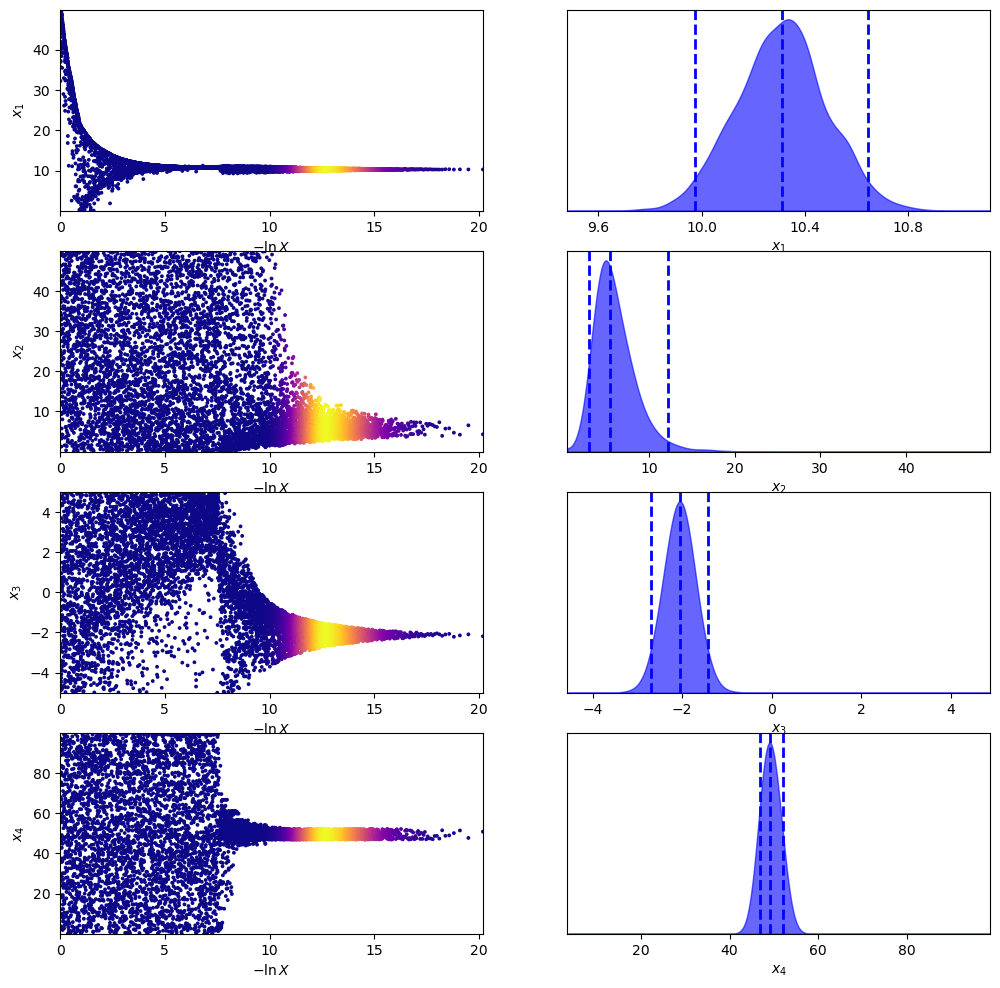

In [18]:
from dynesty import plotting as dyplot
tfig, taxes = dyplot.traceplot(results)

In [19]:
from dynesty import utils as dyfunc
samples = results.samples  
weights = np.exp(results.logwt - results.logz[-1])  

samples_equal = dyfunc.resample_equal(samples, weights)

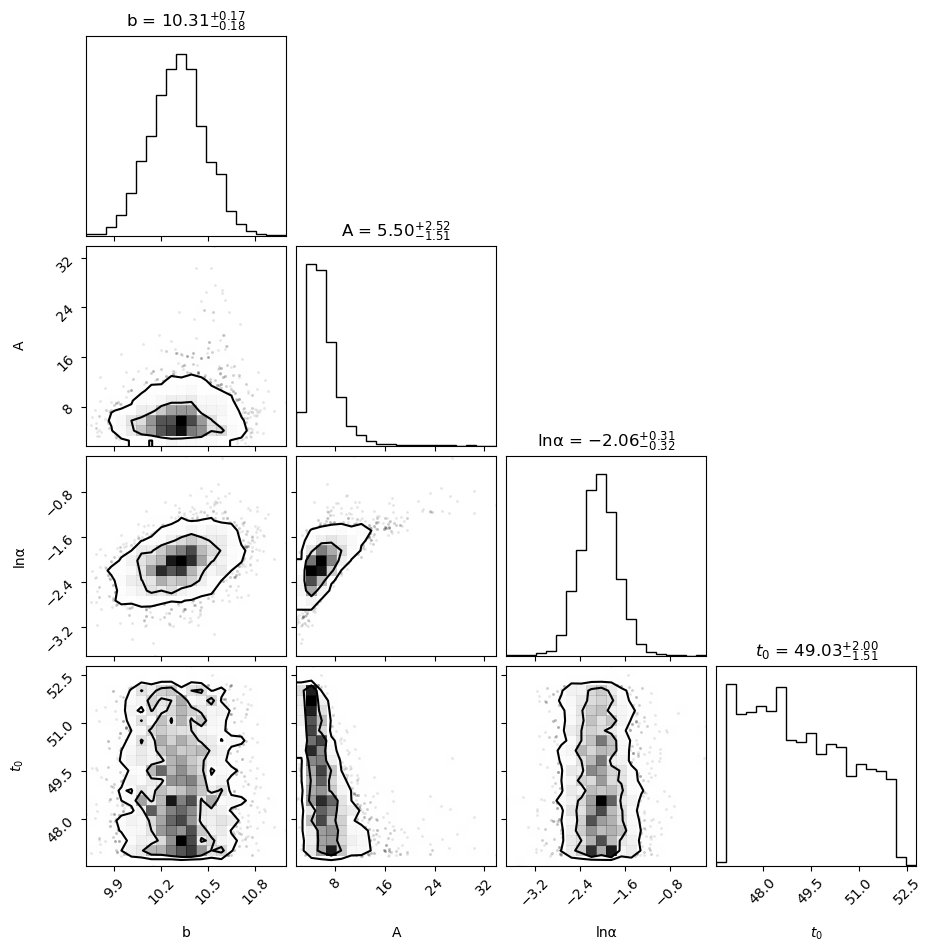

In [20]:
import corner
corner.corner(samples_equal, labels=labels, levels=[0.68, 0.95], show_titles=True);

Parameter estimate (mean):
b  =  10.308292113775977
A  =  6.066104166064261
α  =  0.12733050810667404
to =  49.20012964547254


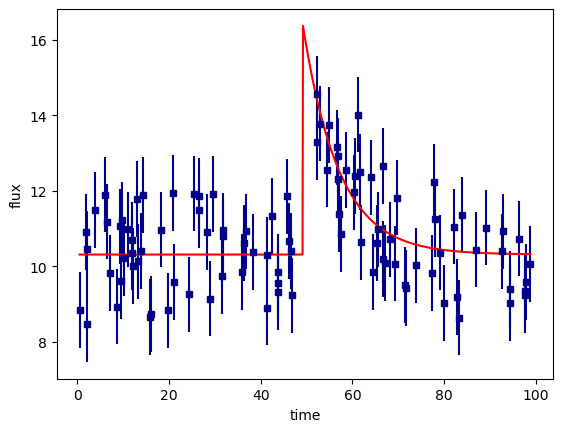

In [21]:
# Burst model with estimated parameters
mean_par = dyfunc.mean_and_cov(samples, weights)[0]
b, A, lnalpha, t0 = mean_par
alpha = np.exp(lnalpha)

print("Parameter estimate (mean):")
print("b  = ", b)
print("A  = ", A)
print("\u03B1  = ", alpha)
print("to = ", t0)
  
time = np.linspace(data[0,0],data[-1,0],1000)
flux = burst(time,mean_par)

# plot
plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None',marker='s',color='darkblue',markersize=3.8)
plt.plot(time,flux,color='red')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

In [22]:
logZ_burst = results['logz'][-1]
logZ_burst

-129.49756345096466

### Comparison between emcee and Dynesty

Parameter estimate (mean):
      dynesty 	 emcee
b  =  10.308 	 10.306
A  =  6.066 	 6.09
α  =  0.127 	 0.128
to =  49.2 	 49.223


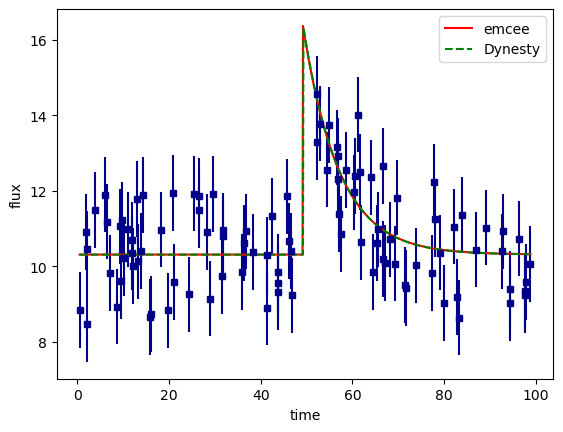

In [23]:
print("Parameter estimate (mean):\n      dynesty \t emcee")
print("b  = ", round(mean_par[0],3), '\t', round(mean_params[0],3))
print("A  = ", round(mean_par[1],3), '\t',round(mean_params[1],3))
print("\u03B1  = ", round(np.exp(mean_par[2]),3), '\t',round(np.exp(mean_params[2]),3))
print("to = ", round(mean_par[3],3), '\t',round(mean_params[3],3))
  
# plot
plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None',marker='s',color='darkblue',markersize=3.8)
plt.plot(time, burst(time,mean_par), color='red', label='emcee')
plt.plot(time, burst(time,mean_params), color='g', ls='dashed', label='Dynesty')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()

### Gaussian

### $y=b+Ae^{-\frac{(t-t_0)^2}{2\sigma^2}}$

In [31]:
def gaussian(t,params):
    b, A, sigma, t0 = params
    return b + A*np.exp(-(t-t0)**2 /2/sigma**2)

def logLikelihood(params):
    y_pred = gaussian(x_data, params)
    return 0.5*np.sum((-(y_data - y_pred)**2 / (2 * y_uncertainty**2)) - np.log(2*np.pi * y_uncertainty**2))

def prior(u):
    return [a + (b - a) * ui for ui, (a, b) in zip(u, bounds)]

bounds = [(0,50), (0,50), (0,30), (0,100)]

ndim = 4

sampler = dynesty.NestedSampler(logLikelihood, prior, ndim)
sampler.run_nested()
results = sampler.results

2482it [00:38, 46.96it/s, bound: 5 | nc: 4 | ncall: 22461 | eff(%): 11.050 | loglstar:   -inf < -216.179 <    inf | logz: -226.247 +/-  0.132 | dlogz: 95.126 >  0.509]      /home/sandokan/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4115it [01:29, 65.16it/s, bound: 39 | nc: 1 | ncall: 47962 | eff(%):  8.580 | loglstar:   -inf < -135.328 <    inf | logz: -144.431 +/-  0.128 | dlogz: 17.193 >  0.509]  /home/sandokan/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large.

4657it [02:08,  4.48it/s, bound: 61 | nc: 53 | ncall: 64147 | eff(%):  7.260 | loglstar:   -inf < -130.836 <    inf | logz: -141.090 +/-  0.135 | dlogz: 12.768 >  0.509]  /home/sandokan/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/sandokan/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more li

/home/sandokan/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/sandokan/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4678it [03:00,  1.31s/it, bound: 117 | nc: 22 | ncal

/home/sandokan/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/sandokan/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4687it [03:38,  2.51s/it, bound: 145 | nc: 9 | ncall

7661it [04:17, 29.78it/s, +500 | bound: 189 | nc: 1 | ncall: 160701 | eff(%):  5.094 | loglstar:   -inf < -118.166 <    inf | logz: -132.755 +/-  0.172 | dlogz:  0.001 >  0.509]


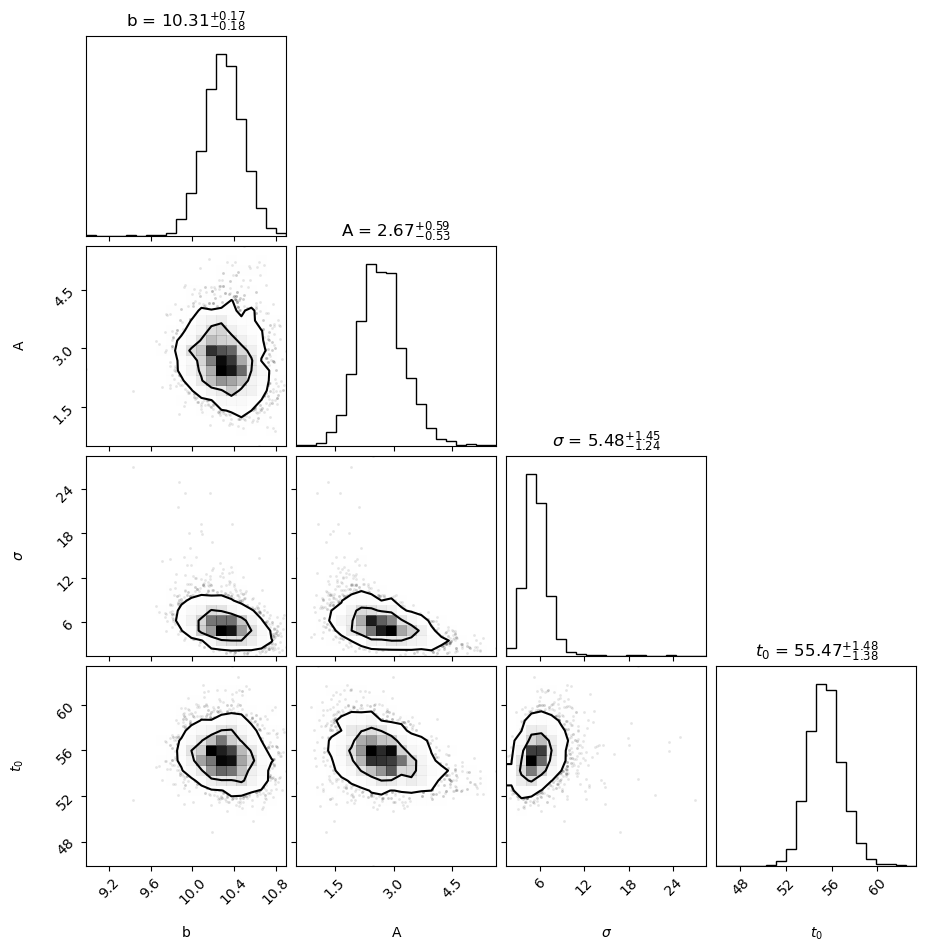

In [32]:
samples = results.samples  
weights = np.exp(results.logwt - results.logz[-1])  

samples_equal = dyfunc.resample_equal(samples, weights)

labels = ['b', 'A', '$\sigma$', '$t_0$']
corner.corner(samples_equal, labels=labels, levels=[0.68, 0.95], show_titles=True);

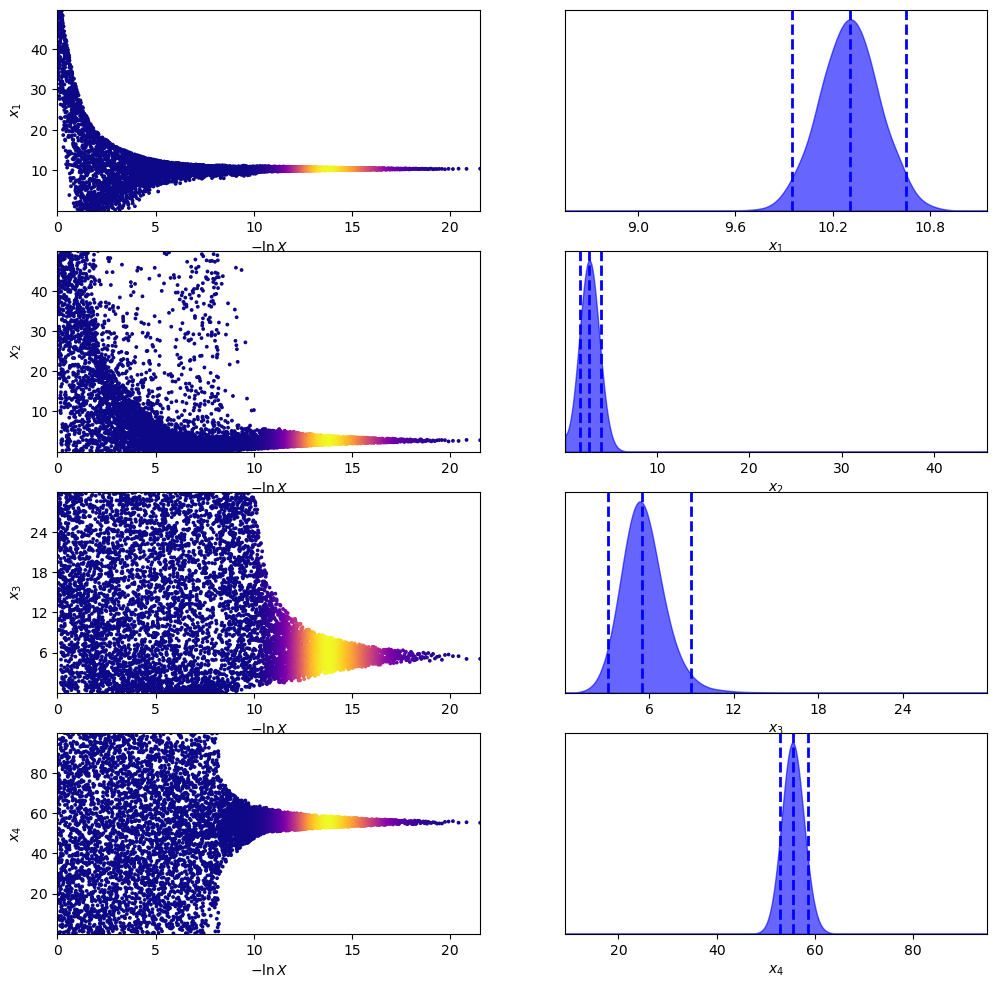

In [33]:
tfig, taxes = dyplot.traceplot(results)

Parameter estimate (mean):
b  =  10.303828485392607
A  =  2.705817530106735
σ  =  5.639697603513171
to =  55.515794363538696


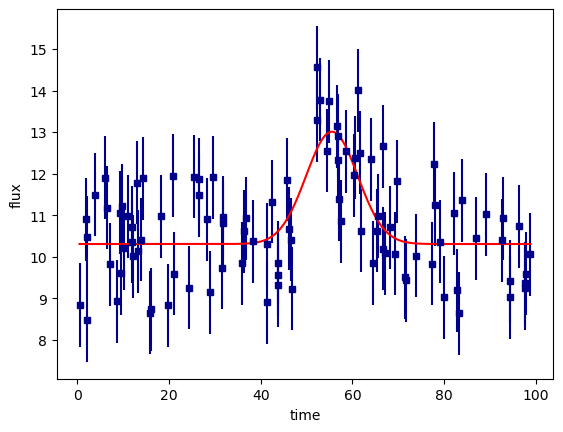

In [34]:
mean_p = dyfunc.mean_and_cov(samples, weights)[0]
b, A, sigma, t0 = mean_p

print("Parameter estimate (mean):")
print("b  = ", b)
print("A  = ", A)
print("σ  = ", sigma)
print("to = ", t0)
  
time = np.linspace(data[0,0],data[-1,0],1000)
fluxG = gaussian(time, mean_p)

# plot
plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None',marker='s',color='darkblue',markersize=3.8)
plt.plot(time, fluxG, color='red')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

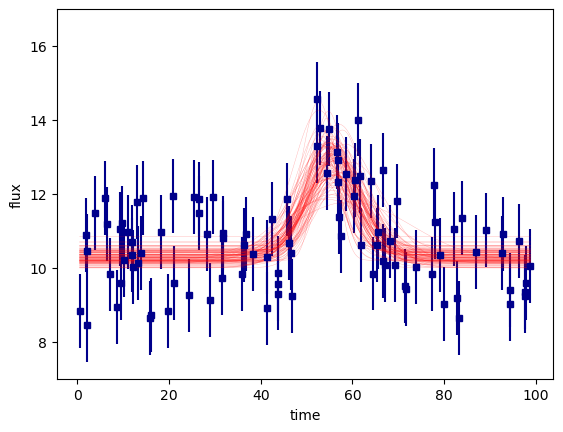

In [35]:
# Plot 100 random samples

plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None',marker='s',color='darkblue',markersize=3.8)

for j in range(100):
    par = samples_equal[np.random.randint(0, len(samples_equal))]    # get random parameter samples from trace
    flux = gaussian(time, par)
    
    plt.plot(time,flux,color='red',alpha=0.3,linewidth=0.3)
plt.xlabel('time')
plt.ylabel('flux')
plt.ylim(7,17)
plt.show()

In [36]:
logZ_gauss = results['logz'][-1]
logZ_gauss

-132.75460706122783

### Bayes factor and Jeffrey's scale

In [37]:
BayesFactor = np.exp( logZ_burst - logZ_gauss )
print(BayesFactor)
if BayesFactor>10:
    print('Strong evidence in favour of the burst model.')

25.97263828576593
Strong evidence in favour of the burst model.
